In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from utilties.imports import *

In [4]:
#typical example setup
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
x_train, y_train, x_valid, y_valid = get_data(MNIST_URL)
x_train, x_valid = normalize_to(x_train, x_valid)

number_hidden = 50
batch_size = 512
num_categories = y_train.max().item()+1

loss_function = F.cross_entropy

training_ds = Dataset(x_train, y_train)
validation_ds = Dataset(x_valid, y_valid)
train_dl = DataLoader(training_ds, batch_size, shuffle = True) #random sampler
valid_dl = DataLoader(validation_ds, batch_size*2, shuffle = False) #sequential sampler
number_fields = [8,16,32,32]

In [5]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [6]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder, partial(AvgStatsCallback, accuracy), CudaCallback, partial(IndependentVarBatchTransformCallback, mnist_view)]
model = SequentialModel(*get_cnn_layers(num_categories, number_fields))
opt = optim.SGD(model.parameters(), lr=0.4)
runner = Runner(cb_funcs=cbfs)
model

SequentialModel(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Lambda()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [7]:
runner.fit(2, model, opt, loss_function, train_dl, valid_dl)

train: [2.1905071875, tensor(0.2455, device='cuda:0')]
valid: [1.41941240234375, tensor(0.5353, device='cuda:0')]
train: [0.656609765625, tensor(0.7974, device='cuda:0')]
valid: [0.2426946533203125, tensor(0.9267, device='cuda:0')]


### Examining Mean and STD through training

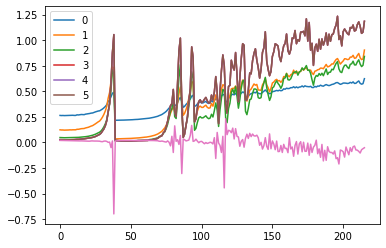

In [8]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

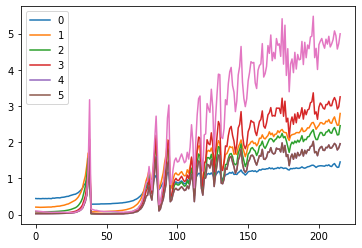

In [9]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

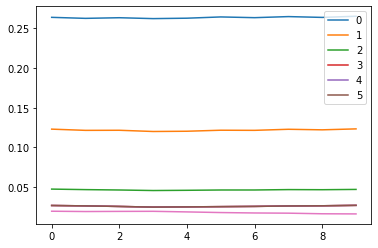

In [10]:
#plotting first 10 batches
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

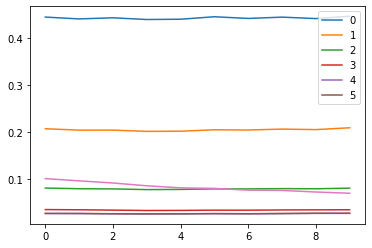

In [11]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

## Getting finer details and telemetry through Pytorch Hooks
##### Downside of Callbacks Class (and subclasses): cannot execute an action at the layer calculation level


In [12]:
model = get_cnn_model(num_categories, number_fields)
opt = optim.SGD(model.parameters(), lr=0.5)
runner = Runner(cb_funcs=cbfs)
#global way to implement hooks
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

#hooking function
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())
#attaching the hooking function to each layer
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [13]:
runner.fit(1, model, opt, loss_function, train_dl, valid_dl)

train: [1.75278453125, tensor(0.3829, device='cuda:0')]
valid: [0.572532861328125, tensor(0.8239, device='cuda:0')]


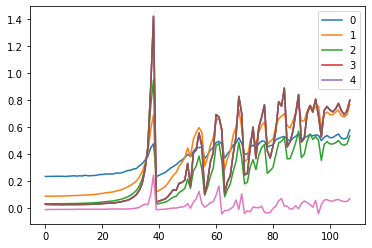

In [15]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

In [16]:
def children(m): return list(m.children())

#used to register a forward hook 
class ForwardHook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'):
        hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [17]:
model = get_cnn_model(num_categories, number_fields)
opt = optim.SGD(model.parameters(), lr=0.5)
runner = Runner(cb_funcs=cbfs)
hooks = [ForwardHook(l, append_stats) for l in children(model)]

In [18]:
runner.fit(1, model, opt, loss_function, train_dl, valid_dl)

train: [2.03919921875, tensor(0.2792, device='cuda:0')]
valid: [1.04270810546875, tensor(0.6761, device='cuda:0')]


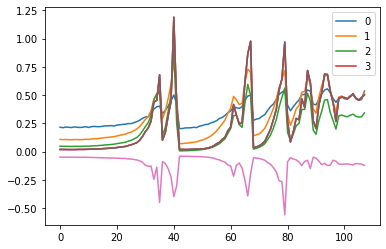

In [19]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### Container Class for Hooks

In [23]:
#numpy style object container
class ListContainer():
    def __init__(self, items): self.items = convert_to_list(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
    
    
#hooks container
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([ForwardHook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self): #removes all registered hooks
        for h in self: h.remove()

In [24]:
model = get_cnn_model(num_categories, number_fields).cuda()
opt = optim.SGD(model.parameters(), lr=0.5)
runner = Runner(cb_funcs=cbfs)
hooks = Hooks(model, append_stats)

In [25]:
print(hooks)
hooks.remove() #
print(hooks)

Hooks (7 items)
[<__main__.ForwardHook object at 0x000001E6801984C8>, <__main__.ForwardHook object at 0x000001E6802EA9C8>, <__main__.ForwardHook object at 0x000001E6802FE988>, <__main__.ForwardHook object at 0x000001E6802FECC8>, <__main__.ForwardHook object at 0x000001E6802FE3C8>, <__main__.ForwardHook object at 0x000001E68035D608>, <__main__.ForwardHook object at 0x000001E6893524C8>]
Hooks (7 items)
[<__main__.ForwardHook object at 0x000001E6801984C8>, <__main__.ForwardHook object at 0x000001E6802EA9C8>, <__main__.ForwardHook object at 0x000001E6802FE988>, <__main__.ForwardHook object at 0x000001E6802FECC8>, <__main__.ForwardHook object at 0x000001E6802FE3C8>, <__main__.ForwardHook object at 0x000001E68035D608>, <__main__.ForwardHook object at 0x000001E6893524C8>]


In [26]:
x,y = next(iter(train_dl))
x = mnist_resize(x).cuda()
print(x.mean(),x.std())

tensor(-0.0004, device='cuda:0') tensor(1.0006, device='cuda:0')


In [28]:
for l in model:
    if isinstance(l, nn.Sequential):
        torch.nn.init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

p = model[0](x)
p.mean(),p.std()

(tensor(0.4872, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.1083, device='cuda:0', grad_fn=<StdBackward0>))

Exception ignored in: <function Hooks.__del__ at 0x000001E680231828>
Traceback (most recent call last):
  File "<ipython-input-20-e2d669b41d3e>", line 25, in __del__
  File "<ipython-input-20-e2d669b41d3e>", line 32, in remove
  File "<ipython-input-20-e2d669b41d3e>", line 11, in __iter__
AttributeError: 'Hooks' object has no attribute 'items'


train: [1.031468125, tensor(0.6751, device='cuda:0')]
valid: [0.2361419677734375, tensor(0.9313, device='cuda:0')]
train: [0.18115224609375, tensor(0.9455, device='cuda:0')]
valid: [0.11600740966796876, tensor(0.9666, device='cuda:0')]


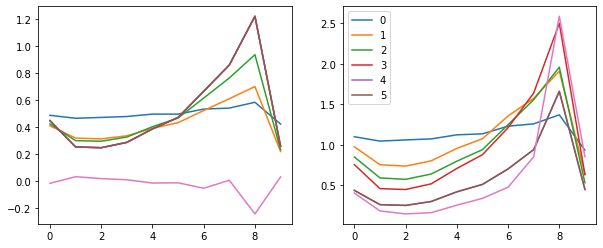

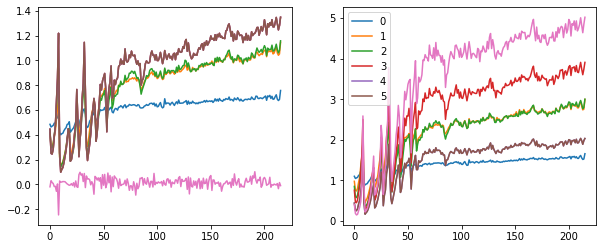

In [30]:
with Hooks(model, append_stats) as hooks:
    runner.fit(2, model, opt, loss_function, train_dl, valid_dl)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));